<center>
    <h1>Housing Prices Predictive Modelling</h1>
<h3>This notebook serves to document the process of building a predictive model<br> based on the provided data for the housing prices of Ames, Iowa<br><br>
    EDSA - Team 5 - 2019</h3>
<h4>Please note that this notebook only shows the best way we could predict the housing prices and not all the different methods we tried.</h4>
</center>
    
    

<a id='Index'></a>
***
# Index

1. [Importing Packages and the Data](#section1)

2. [Looking at the data](#section2)

3. [Data Descriptions](#section3)

4. [Filling Missing Values](#section4)

5. [Dealing with Outliers](#section5)

6. [Distribution of Sale Price](#section6)

7. [Feature Engineering](#section7)

8. [Label Encoding](#section8)

9. [Transforming the Data](#section9)

10. [Modelling](#section10)

11. [Output for Kaggle Submission](#section11)

***

## 1. Importing Packages and Data
<a id="section1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test2 = pd.read_csv("test.csv")
len_train = train.shape[0]
## concatenate the two datasets
combined = pd.concat([train,test], sort=False)

FileNotFoundError: File b'train.csv' does not exist

## 2. Looking at the Data
<a id="section2"></a>

Our first step was to familiarise ourselves with the dataset. We did this by first studying the descriptions of the columns given. Then by opening the datasets in Excel to have a broader view of the data and all its features. Once we had an understanding of the data we then looked more closely at it.

### Looking at the shape

In [3]:
print(train.shape)
print(test.shape)

NameError: name 'train' is not defined

##### Let's take a brief look at how our combined data looks like:

In [4]:
#Checking data types
combined.select_dtypes(include='object').head()

NameError: name 'combined' is not defined

In [5]:
# Numerical feautures graphs

num_graphs = list(train[list(train.describe().columns)[1:]].corr()['SalePrice'].sort_values(ascending=False).reset_index()['index'].values)[1:]

plt.subplots(figsize=(15, 30))
for i, col in enumerate(num_graphs):
    ax = plt.subplot(9, 4, i+1)    
    sns.regplot(x = col,y = 'SalePrice', data = train[train.columns[1:]], ax=ax)
    plt.title(col+' vs '+'SalePrice'+' : '+str(round(train.corr()['SalePrice'][col]*100,2))+'%');
    
plt.tight_layout()

NameError: name 'train' is not defined

[Back to Index](#Index)

***
<a id="section3"></a>
## 3. Data descriptions
from reading through the data description document, we found that:
- most of the NaN values were due to an error in data entry. A NaN under 'GarageType' means 'No Garage'
- most numerical NaN values were supposed to be 0. A NaN under 'GarageYrBlt' should be 0 because there was 'No Garage'
- And also we decided on setting the right datatype to the 'MSSubClass' features of the dataset below:

In [6]:
#Setting categorical column with numerical values to string
combined['MSSubClass'] = combined['MSSubClass'].astype(str)

NameError: name 'combined' is not defined

- Checking the numerical datatype 

In [7]:
#Check numerical data types
combined.dtypes[combined.dtypes != "object"].head()

NameError: name 'combined' is not defined

In [8]:
combined.select_dtypes(include='object').isnull().sum()[combined.select_dtypes(include='object').isnull().sum()>0]

NameError: name 'combined' is not defined

##### A little bar plot for missing data 

In [9]:
# View where training data is missing 
missing_data = combined.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data.sort_values(inplace=True)
missing_data.plot.bar(title='Missing Combined Data');

NameError: name 'combined' is not defined

[Back to Index](#Index)

<a id='section4'></a>
***
## 4. Fill NaN values and Cleaning Data
Create two lists of columns, one where 'None' will be filled and the other the mode

In [10]:
#Based on data descriptions the following columns NA's will be filled with 'None'
none_columns = ('Alley','Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','Electrical','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
           'PoolQC','Fence','MiscFeature')
#Based on data descriptions the following columns NA's will be filled with mode
mode_columns = ('MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional')

In [11]:
#Fill categorical NA's
for col in none_columns:
    train[col]=train[col].fillna('None')
    test[col]=test[col].fillna('None')
    
for col in mode_columns:
    train[col]=train[col].fillna(train[col].mode()[0])
    test[col]=test[col].fillna(train[col].mode()[0])

NameError: name 'train' is not defined

##### Based on data descriptions the following numerical columns will be filled with 0
- Fill the NAs with zeros for the numerical columns, except for the LotFrontage. LotFrontage is filled with the median of the neighborhood

In [12]:
#Based on data descriptions the following numerical columns will be filled with 0
zeros = ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars','GarageArea')

for col in zeros:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

NameError: name 'train' is not defined

- Fill the LotFrontage with the average of the Neighborhoood

In [13]:
#fill Lotfrontage with average of the neighbourhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

NameError: name 'train' is not defined

##### Removing Utilities as all values are the same, no predictive value

In [14]:
train = train.drop('Utilities', 1)
test = test.drop('Utilities', 1)

NameError: name 'train' is not defined

[Back to Index](#Index)

***
<a id='section5'></a>
## 5. Dealing with outliers:
From the GrLivArea graph below there are two significant outliers that appear where GrLivArea > 4000 that will be removed
and this is projected below:

NameError: name 'train' is not defined

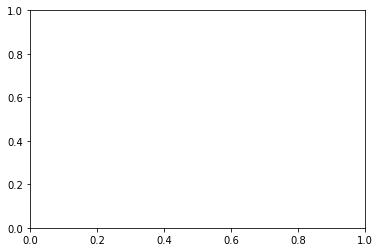

In [15]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.show()

- Removing the outliers

In [16]:
#removing outliers recomended by author, but less than $300 000
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

NameError: name 'train' is not defined

- After the removal of the outliers here is the above graph

NameError: name 'train' is not defined

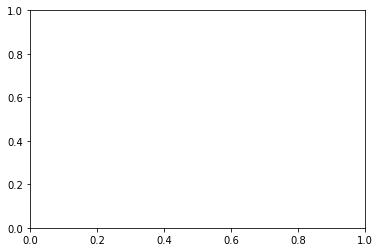

In [17]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'], c='grey')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.show()

- The two data points that looks 'like' outliers follow the trend therefore can't be assumed to be outliers

[Back to Index](#Index)

***
<a id='section6'></a>
## 6. Distribution of Sales Price

In [18]:
(mu, sigma) = norm.fit(train['SalePrice'])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'],fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1, 2, 2)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
quantile_plot=stats.probplot(train['SalePrice'], plot=plt)

NameError: name 'train' is not defined

-  The Above graphs can clearly demonstrate the skewness 
-  And below we normalize the data and we will have a look at it again after

In [19]:
# Fix the Skewness using 'nplog'
train["SalePrice"] = np.log1p(train["SalePrice"])

NameError: name 'train' is not defined

#### Now let's look at the skewness again :

In [20]:
(mu, sigma) = norm.fit(train['SalePrice'])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'],fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1, 2, 2)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
quantile_plot=stats.probplot(train['SalePrice'], plot=plt)

NameError: name 'train' is not defined

In [21]:
#Set the length of the train and concat once again to create the combined DF
len_train=train.shape[0]
print(train.shape)
combined = pd.concat([train,test], sort=False)

NameError: name 'train' is not defined

[Back to Index](#Index)

***
<a id='section7'></a>
## 7. Feature Engineering

In [22]:
# Adding Features
combined['TotalSF'] = combined['TotalBsmtSF'] + combined['1stFlrSF'] + combined['2ndFlrSF']

NameError: name 'combined' is not defined

In [23]:
# check for NAs once more
combined.select_dtypes(include=['int','float','int64']).isnull().sum()[combined.select_dtypes(include=['int','float','int64']).isnull().sum()>0]

NameError: name 'combined' is not defined

[Back to Index](#Index)

***
<a id='section8'></a>
## 8. Labeling Enconding

In [24]:
#Label Encoding

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(combined[c].values)) 
    combined[c] = lbl.transform(list(combined[c].values))

# shape        
print('Shape combined: {}'.format(combined.shape))

NameError: name 'combined' is not defined

##### Let's once more review the combined data

In [25]:
combined.head()

NameError: name 'combined' is not defined

##### Select numeric features

In [26]:
combined.select_dtypes(include=['int','int64','float']).columns

NameError: name 'combined' is not defined

[Back to Index](#Index)

***
<a id='section9'></a>
## 9. Transforming the Data
#### Let's fix the skewness of the data

###### After a few trial and errors we realized that including box cox fixes improves our model scor
- BoxCox Implmentation

In [27]:
num_feats = combined.dtypes[combined.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = combined[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness.drop('SalePrice', 0)
skewness.head(15)

NameError: name 'combined' is not defined

In [28]:
#Correct for skewness by using boxcox1p
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    combined[feat] = boxcox1p(combined[feat], lam)

NameError: name 'skewness' is not defined

In [29]:
#Get Dummies
combined = pd.get_dummies(combined)
len_train = train.shape[0]

NameError: name 'combined' is not defined

In [30]:
train.shape

NameError: name 'train' is not defined

[Back to Index](#Index)

***
<a id='section10'></a>
## 10. Modelling
#### test_train_split, lasso vs ridge vs linear, etc.


RE-split the combined data to get it ready for our models

In [31]:
train = combined[:len_train]
y_train = train.SalePrice.values
train = train.drop(['Id','SalePrice'], 1)
test = combined[len_train:]
test = test.drop(['Id','SalePrice'], 1)
train.shape

NameError: name 'combined' is not defined

### Cross Validation
It's simple way to calculate error for evaluation. 

**KFold( )** splits the train/test data into k consecutive folds, we also have made shuffle attrib to True.

**cross_val_score ( )** evaluate a score by cross-validation. 

In [32]:
#Validation function - Courtesy of ....
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


### Linear Regression

In [33]:
LinReg = LinearRegression()
score = rmsle_cv(LinReg)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: name 'train' is not defined

### Ridge Regression
- It shrinks the parameters, therefore it is mostly used to prevent multicollinearity.
- It reduces the model complexity by coefficient shrinkage.
- It uses L2 regularization technique.

In [34]:
RG = Ridge(alpha=22)
score = rmsle_cv(RG)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: name 'train' is not defined

### Lasso Regression
LASSO (Least Absolute Shrinkage Selector Operator), is quite similar to ridge.

In case of lasso, even at smaller alpha’s, our coefficients are reducing to absolute zeroes.
 Therefore, lasso selects the only some feature while reduces the coefficients of others to zero. This property is known as feature selection and which is absent in case of ridge.
 
- Lasso uses L1 regularization technique.
- Lasso is generally used when we have more number of features, because it automatically does feature selection.

In [35]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: name 'train' is not defined

### Gradient Boosting Regression



In [36]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: name 'train' is not defined

### Random Forest Regression

In [37]:
RandomForest = RandomForestRegressor(n_estimators=150, random_state = 1)
score = rmsle_cv(RandomForest)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: name 'train' is not defined

### XGBoost

In [38]:
data_dmatrix = xgb.DMatrix(data=train.values,label=y_train)
XGBoost = xgb.XGBRegressor(random_state = 5, max_depth = 2, alpha = 10, n_estimators = 1000,
                           learning_rate = 0.05, objective = 'reg:squarederror', colsample_bytree = 0.1,
                          subsample = 0.75)
score = rmsle_cv(XGBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: name 'train' is not defined

### We then fit the training data to all models

In [39]:
#Fit the training dataset on every model
#lr = LinReg.fit(train, y_train)
ls = lasso.fit(train, y_train)
rg = RG.fit(train, y_train)
#rf = RandomForest.fit(train, y_train)
gb = GBoost.fit(train, y_train)
xg = XGBoost.fit(train,y_train)

NameError: name 'train' is not defined

In [40]:
pred_ls = np.expm1(ls.predict(test))
pred_rg = np.expm1(rg.predict(test))
pred_gb = np.expm1(gb.predict(test))
pred_xg = np.expm1(xg.predict(test))

NameError: name 'ls' is not defined

### Mean of all model's prediction.
np.expm1 ( ) is used to calculate exp(x) - 1 for all elements in the array. 

In [41]:
final_predictions = (pred_ls + pred_rg + pred_gb + pred_xg) / 4
# Tried weighted average, scored less
#final_weighted = (0.25 * pred_ls) + (0.30 * pred_rg) + (0.20 * pred_gb) + (0.25 * pred_xg)

NameError: name 'pred_ls' is not defined

### Check the predictions

In [42]:
final_predictions

NameError: name 'final_predictions' is not defined

***
<a id='section11'></a>
## 11. Output for Kaggle submission

In [43]:
#Output to CSV
output_avg = pd.DataFrame({'Id':test2.Id, 'SalePrice': final_predictions})
output_avg.to_csv('submission.csv', index=False)

NameError: name 'test2' is not defined

[Back to Index](#Index)
***